---
title: "Supervised Learning"
format:
    html: 
        toc: true
        code-fold: false
        embedded-resouces: true
---

# Introduction and Motivation


# Data Preprocessing
The core of the data preprocessing process took place in the Counterfactual Data Balancing tab, where representative samples were drawn from the Illinois incarcerated population to simulate a comparable group of individuals who were not exonerated. The racial distribution was carefully modeled to reflect the broader incarcerated population, ensuring the simulated group was as representative as possible. This dataset was then merged with the exoneration data to create a final, balanced dataset. By balancing the data in this way,a clean and reliable foundation for building supervised learning models was created to analyze and predict the factors most closely associated with exoneration outcomes.


## Sample of Balanced Dataset

In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

exonerees_balanced = pd.read_csv('../../data/processed-data/exonerees_balanced.csv')
exonerees_balanced.head()

,last_name,first_name,age,sex,state,latitude,longitude,worst_crime_display,sentence,sentence_in_years,...,witness_tampering_or_misconduct_interrogating_co_defendant,misconduct_in_interrogation_of_exoneree,perjury_by_official,prosecutor_lied_in_court,tag_sum,geocode_address,Race_orig,Label,County,Race
0,Abbott,Cinque,19.0,male,Illinois,41.819738,-87.756525,Drug Possession or Sale,Probation,0.0,...,0.0,0.0,0.0,0.0,7.0,"Cook County, Illinois, United States",Black,Exonerated,Cook,Black
1,Abernathy,Christopher,17.0,male,Illinois,41.819738,-87.756525,Murder,Life without parole,100.0,...,0.0,1.0,0.0,0.0,10.0,"Cook County, Illinois, United States",White,Exonerated,Cook,White
2,Abrego,Eruby,20.0,male,Illinois,41.819738,-87.756525,Murder,90 years,90.0,...,1.0,1.0,1.0,0.0,9.0,"Cook County, Illinois, United States",Hispanic,Exonerated,Cook,NaN
3,Adams,Demetris,22.0,male,Illinois,41.819738,-87.756525,Drug Possession or Sale,1 year,1.0,...,0.0,0.0,0.0,0.0,7.0,"Cook County, Illinois, United States",Black,Exonerated,Cook,Black
4,Adams,Kenneth,22.0,male,Illinois,41.819738,-87.756525,Murder,75 years,75.0,...,1.0,0.0,0.0,0.0,11.0,"Cook County, Illinois, United States",Black,Exonerated,Cook,Black


## Race Distribution by Exoneration Status 

A crosstabulation was conducted to analyze the distribution of race between exonerated and non-exonerated individuals within the balanced dataset. Using the `pd.crosstab()` function, the proportion of each racial category across the two groups was calculated:

- **Exonerated** individuals: those who were wrongfully convicted and later cleared.  
- **Non-Exonerated** individuals: a simulated group drawn from the broader incarcerated population.  

By normalizing the values, the crosstab presents the relative frequency of each racial category within both groups. This allows us to pinpoint patterns or disparities in the racial composition of exonerated individuals compared to the simulated non-exonerated group.

In [2]:
pd.crosstab(
    exonerees_balanced['Label'], exonerees_balanced['Race'],
    margins=True,
    normalize=True
)

Race,Black,Latino,Other,White,All
Label,,,,,
Exonerated,0.412636,0.000000,0.000000,0.046397,0.459033
Non-Exonerated,0.287266,0.090819,0.004936,0.157947,0.540967
All,0.699901,0.090819,0.004936,0.204344,1.000000


- **Exonerated Group**: The majority are Black (41.2%) and White (4.6%), with no representation for Latino or Other races.  
- **Non-Exonerated Group**: The racial distribution includes 28.7% Black, 9.1% Latino, 0.5% Other, and 15.8% White.  
- **Overall**: The total racial distribution reflects the balanced nature of the dataset, with 69.9% Black, 9.1% Latino, and smaller proportions for Other and White categories.  

This breakdown provides an overview of how race is distributed within the dataset, ensuring transparency in the balancing process and highlighting any disparities between the two groups.

## Exoneration Label Mapping
In this step, the labels identifying whether an individual was exonerated or not were converted into a binary format to prepare the dataset for supervised learning. The `Label` column was mapped as follows:  
- `'Exonerated'` → `1`  
- `'Non-Exonerated'` → `0`  

For clarity and consistency, the column was renamed **"Exonerated"**, making it easier to interpret the target variable during modeling. To streamline the dataset for further processing, only the relevant features were retained: **Race**, **County**, and the newly mapped **Exonerated** column.  

A quick preview of the transformed data confirmed the changes, showing the updated binary labels alongside the selected features. This clean, focused dataset will serve as the foundation for building machine learning models in the next steps.

In [3]:
# Map 'Exonerated' to 1 and 'Non-Exonerated' to 0
exonerees_balanced['Label'] = exonerees_balanced['Label'].map({'Exonerated': 1, 'Non-Exonerated': 0})

# Rename the column to 'exonerated'
exonerees_balanced.rename(columns={'Label': 'Exonerated'}, inplace=True)
# Keep relevant features
data = exonerees_balanced[['Race', 'County', 'Exonerated']].copy()

# Preview the transformed data
print(data.head())



    Race County  Exonerated
0  Black   Cook           1
1  White   Cook           1
2    NaN   Cook           1
3  Black   Cook           1
4  Black   Cook           1


## One Hot Encoding  

One hot encoding was applied to convert the categorical features **"Race"** and **"County"** into a numerical format suitable for machine learning models. Since algorithms like logistic regression and other supervised models require numerical inputs, this transformation ensures these features can be effectively incorporated during training.  

Each unique value in the **"Race"** and **"County"** columns was transformed into its own binary column, where a value of `1` indicates the presence of a specific category, and `0` indicates its absence. To avoid any loss of information, all categories were retained during the encoding process.  

Once encoded, the original **"Race"** and **"County"** columns were dropped and replaced with their respective binary columns. This transformation resulted in a dataset with **64 columns**, including the binary target variable **"Exonerated"**. The final dataset is now fully numeric, clean, and well-structured for training supervised learning models.  


In [4]:
# Perform one-hot encoding without dropping any category
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
encoded_features = encoder.fit_transform(data[['Race', 'County']])

# Create a DataFrame for the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Race', 'County']))

# Concatenate encoded features with the original dataset
data = pd.concat([data.drop(columns=['Race', 'County']), encoded_df], axis=1)

# Preview the data
data.head()



,Exonerated,Race_Black,Race_Latino,Race_Other,Race_White,Race_nan,County_Adams,County_Bond,County_Boone,County_Brown,...,County_Sangamon,County_St. Clair,County_Stephenson,County_Tazewell,County_Vermilion,County_Washington,County_Will,County_Williamson,County_Winnebago,County_Woodford
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training and Testing Strategy  

In this step, the dataset was split into training and testing sets to evaluate the performance of the supervised learning models. The **train-test split** method from `sklearn.model_selection` was used to create a clear separation between the data used to train the model and the data reserved for testing its performance.  

An **80-20 split** was implemented, with 80% of the data (876 samples) designated for training and the remaining 20% (220 samples) held out for testing. The 80-20 ratio is a widely accepted standard in machine learning, striking a balance between providing the model with enough data to learn patterns effectively and retaining sufficient unseen data to evaluate its generalization performance. The larger training portion gives the model ample opportunity to identify relationships in the data, while the smaller test set ensures a reliable measure of accuracy and consistency.  

To keep the results reproducible, a **random seed** (`random_state=42`) was applied, ensuring that the split remains consistent across multiple runs. This approach establishes a strong foundation for training and testing the supervised learning models, minimizing the risk of overfitting while still allowing for robust performance evaluation.  


In [5]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data.drop(columns=['Exonerated'])  # Drop the target column
y = data['Exonerated']  # Target column

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (876, 62)
Test set shape: (220, 62)


# Model Selection  

To predict the factors associated with exoneration, several supervised learning algorithms were selected: **Logistic Regression**, **Naive Bayes**, **Random Forest**, and **K-Nearest Neighbors (KNN)**. These models were chosen for their balance of simplicity, interpretability, and effectiveness in solving binary classification problems. Each algorithm offers distinct advantages, allowing for a thorough comparison of predictive performance across models.  

### Model Evaluation Metrics  

The performance of each model was evaluated using key **binary classification metrics** to ensure a comprehensive assessment:  

- **Accuracy**: Measures the overall correctness of the model's predictions.  
- **Precision**: Assesses the proportion of predicted positives that were actually correct.  
- **Recall**: Measures the model’s ability to identify all positive cases.  
- **F1 Score**: A balanced measure that combines Precision and Recall into a single score.  
- **ROC-AUC**: Evaluates the model's capability to distinguish between positive and negative classes.  

To complement these metrics, the following visualizations were utilized for deeper interpretation:  

- **ROC Curve**: Shows the trade-off between True Positive Rate and False Positive Rate at various thresholds, offering insights into classification performance.  
- **Confusion Matrix**: Breaks down predictions into True Positives, True Negatives, False Positives, and False Negatives to summarize performance.  
- **Calibration Curve**: Measures how well the predicted probabilities align with actual outcomes, identifying whether the model is overconfident or underconfident.  

### Results  

A **Model Performance Summary** was compiled for each algorithm, including core metrics such as Accuracy, Precision, Recall, F1 Score, and ROC-AUC. Visual aids like **ROC Curves**, **Confusion Matrices**, and **Calibration Curves** were included to validate and interpret model behavior effectively. This comprehensive approach ensures that each model’s performance and reliability are fully evaluated.  

## Logistic Regression  

Logistic Regression was selected as the baseline model due to its simplicity, efficiency, and strong interpretability. As a linear model, it is particularly well-suited for binary classification tasks, such as predicting whether an individual is exonerated (`1`) or not (`0`). Logistic Regression estimates the probability of class membership, offering clear insights into the relationship between the input features and the target variable.  

A key advantage of Logistic Regression is its assumption of a linear relationship between the independent variables and the log-odds of the outcome. This assumption works effectively when the dataset is well-preprocessed and balanced, as is the case here.  

By serving as the benchmark model, Logistic Regression provides a baseline for performance comparison. This allows for a clear evaluation of whether more complex models, such as **Random Forest** or **KNN**, can achieve improved predictive accuracy in exchange for additional computational complexity.  


### Model Performance Summary

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Logistic Regression Model
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)

# Predictions and Probabilities
log_y_pred = log_model.predict(X_test)
log_y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
log_accuracy = accuracy_score(y_test, log_y_pred)
log_precision = precision_score(y_test, log_y_pred)
log_recall = recall_score(y_test, log_y_pred)
log_f1 = f1_score(y_test, log_y_pred)
log_roc_auc = roc_auc_score(y_test, log_y_pred_proba)

print(f"Logistic Regression - Accuracy: {log_accuracy:.2f}, Precision: {log_precision:.2f}, Recall: {log_recall:.2f}, F1 Score: {log_f1:.2f}, ROC-AUC: {log_roc_auc:.2f}")

Logistic Regression - Accuracy: 0.89, Precision: 0.90, Recall: 0.88, F1 Score: 0.89, ROC-AUC: 0.95


The **Logistic Regression** model delivered strong performance across all evaluation metrics. An **accuracy** of 0.89 indicates that the model correctly predicted exoneration outcomes 89% of the time. The **precision** score of 0.90 shows that 90% of the individuals predicted as exonerated were truly exonerated, highlighting the model's ability to minimize false positives. Similarly, the **recall** of 0.88 demonstrates that the model successfully identified 88% of all actual exonerated cases, proving its effectiveness at capturing true positives.  

The **F1 Score**, which balances precision and recall, came in at 0.89, confirming strong overall classification performance. Finally, the **ROC-AUC score** of 0.95 reflects the model's exceptional ability to distinguish between exonerated and non-exonerated individuals across different probability thresholds. A score this high indicates that the model is highly effective at separating the two classes with minimal overlap in predictions.  

These results underscore that Logistic Regression serves as a reliable and high-performing baseline model for predicting exoneration outcomes.  


### ROC Curve

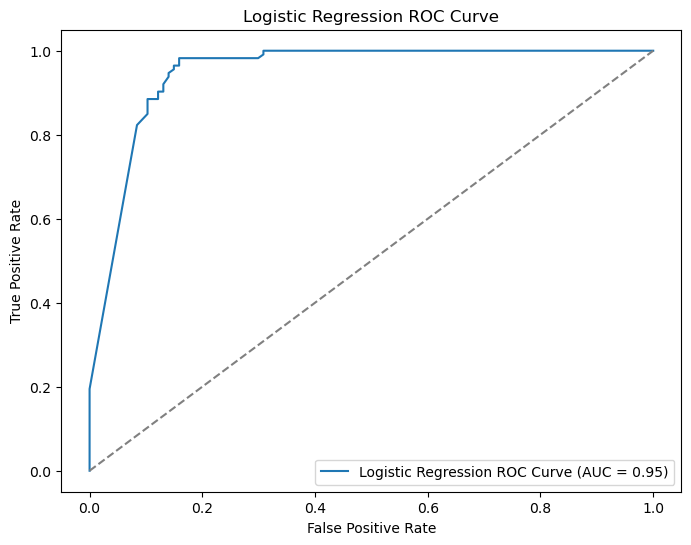

In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression ROC Curve (AUC = {log_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend(loc="lower right")
plt.show()

The **ROC Curve's** steep rise toward the top-left corner indicates strong performance in distinguishing between exonerated and non-exonerated individuals. The **AUC (Area Under the Curve)** value of **0.95** confirms the model’s exceptional discriminatory power. While a perfect model achieves an AUC of 1.0 and a random classifier yields an AUC of 0.5 (represented by the dashed diagonal line), the high AUC score here demonstrates that the Logistic Regression model is highly effective at separating the two classes with minimal false classifications.  This ROC curve, combined with the corresponding AUC score, highlights the model’s efficient performance and reliability in predicting exoneration outcomes.  


### Confusion Matrix

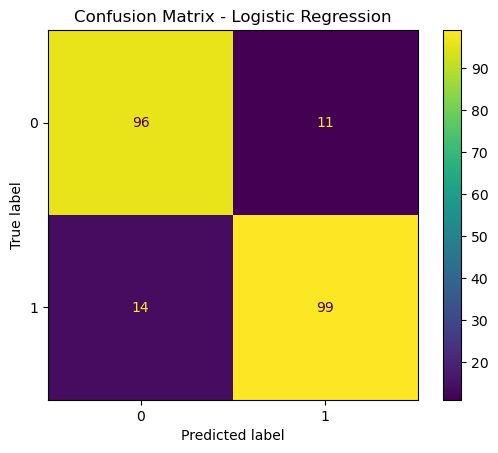

In [12]:
## Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The **Confusion Matrix** for the Logistic Regression model provides a clear breakdown of predictions against actual outcomes, highlighting the following results:

- **True Negatives (Top-Left)**: 96 cases were correctly classified as non-exonerated.  
- **False Positives (Top-Right)**: 11 cases were incorrectly predicted as exonerated.  
- **False Negatives (Bottom-Left)**: 14 cases were incorrectly classified as non-exonerated.  
- **True Positives (Bottom-Right)**: 99 cases were correctly identified as exonerated.  

The model demonstrates strong predictive accuracy, with a high count of true positives and true negatives. While the false positive and false negative rates are relatively low, they still pinpoint areas that could benefit from further refinement. Specifically, the **14 false negatives** reflect cases where the model failed to identify individuals who were exonerated, a critical consideration for future adjustments. On the other hand, the **11 false positives** represent instances where exoneration was incorrectly predicted, signaling a slight overreach in classification. 

### Calibration Curve

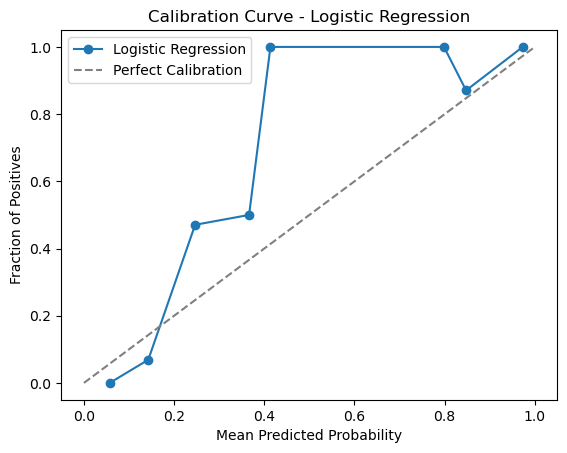

In [13]:
## Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, log_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Logistic Regression")
plt.legend()
plt.show()

The **Calibration Curve** reveals that the model's predictions are generally well-calibrated but show slight deviations, particularly at the extremes:  

- At lower probabilities (**0.0 to 0.2**), the model underestimates the actual fraction of positives, indicating a conservative bias in this range.  
- For mid-range probabilities (**0.4 to 0.6**), the predictions align closely with the observed outcomes, reflecting strong calibration in this critical range.  
- At higher probabilities (**0.8 to 1.0**), the model slightly overestimates, as the fraction of positives reaches 1.0 earlier than the ideal calibration line.  

These results suggest that while the model performs reliably across the mid-to-high probability ranges, minor misalignments occur at the extremes. These deviations highlight areas where additional tuning or recalibration could further improve probability estimates. Despite this, the overall calibration remains strong, confirming the model's effectiveness in producing meaningful and interpretable probability scores for predicting exoneration outcomes.  


## Naive Bayes

### Model Performance Summary

In [7]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions and Probabilities
nb_y_pred = nb_model.predict(X_test)
nb_y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred)
nb_recall = recall_score(y_test, nb_y_pred)
nb_f1 = f1_score(y_test, nb_y_pred)
nb_roc_auc = roc_auc_score(y_test, nb_y_pred_proba)

print(f"Naive Bayes - Accuracy: {nb_accuracy:.2f}, Precision: {nb_precision:.2f}, Recall: {nb_recall:.2f}, F1 Score: {nb_f1:.2f}, ROC-AUC: {nb_roc_auc:.2f}")

Naive Bayes - Accuracy: 0.83, Precision: 0.75, Recall: 0.99, F1 Score: 0.85, ROC-AUC: 0.86


The **Naive Bayes** model achieved an **accuracy** of 0.83, meaning it correctly predicted 83% of the outcomes. A key highlight is the **recall** score of **0.99**, demonstrating the model’s exceptional ability to identify actual positives (exonerated individuals) while minimizing false negatives. This makes Naive Bayes particularly advantageous in scenarios where capturing all exoneration cases is critical. However, the **precision** score of **0.75** reveals that 25% of the predicted positives were incorrect, pointing to a higher rate of false positives. The **F1 Score**, which strikes a balance between precision and recall, is **0.85**, indicating solid overall performance despite the trade-off in precision. Additionally, the **ROC-AUC score** of **0.86** confirms that the model effectively differentiates between exonerated and non-exonerated individuals, though it falls slightly short of the performance achieved by Logistic Regression. These results highlight that Naive Bayes prioritizes recall—ensuring most true positives are captured—at the expense of precision. This trade-off makes the model particularly useful in applications where minimizing missed exonerations outweighs the cost of false positives.  


### ROC Curve

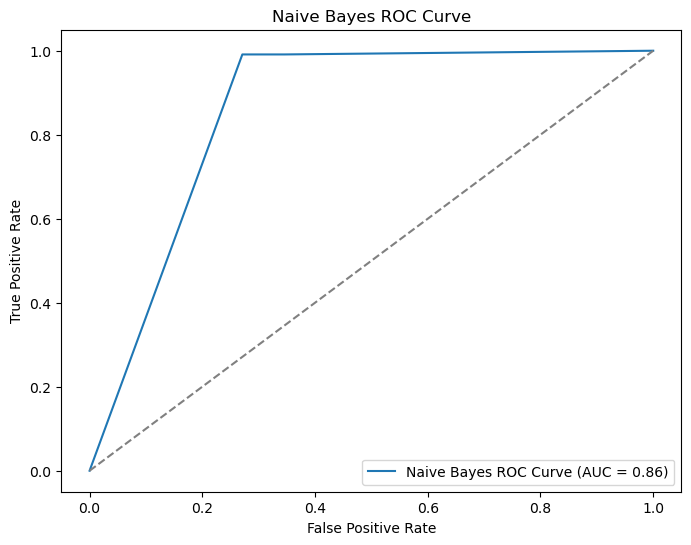

In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, nb_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Naive Bayes ROC Curve (AUC = {nb_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC Curve")
plt.legend(loc="lower right")
plt.show()

The **ROC Curve** demonstrates that the Naive Bayes model effectively distinguishes between exonerated and non-exonerated individuals, rising steeply toward the top-left corner. The **AUC (Area Under the Curve)** value of **0.86** confirms strong overall performance, reflecting the model’s ability to separate the two classes. That said, the slightly lower AUC compared to Logistic Regression suggests that Naive Bayes is less precise when ranking positive predictions. This aligns with its earlier results, where high recall (capturing nearly all true positives) came at the cost of lower precision. The shape of the curve further reveals that while the model achieves excellent sensitivity, it is more prone to false positives at certain thresholds. Ultimately, the Naive Bayes ROC curve highlights the model’s strength in identifying exonerated individuals, reinforcing its reliability for scenarios where capturing true positives is prioritized over reducing false positives.  


### Confusion Matrix

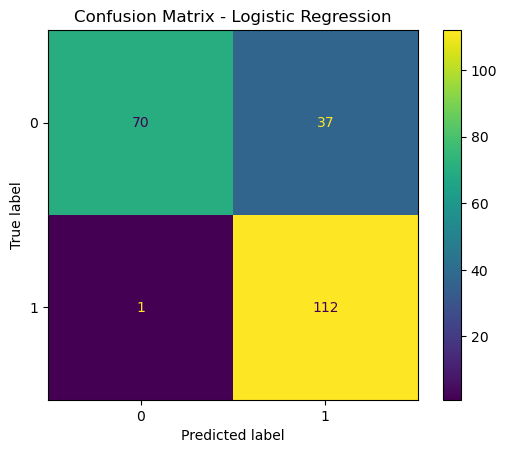

In [15]:
## Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The **Confusion Matrix** for the Logistic Regression model provides a detailed breakdown of its performance in predicting exoneration outcomes. The matrix shows the following:

- **True Negatives (Top-Left)**: 70 instances were correctly classified as non-exonerated.  
- **False Positives (Top-Right)**: 37 instances were incorrectly predicted as exonerated.  
- **False Negatives (Bottom-Left)**: Only 1 instance was incorrectly classified as non-exonerated.  
- **True Positives (Bottom-Right)**: 112 instances were correctly classified as exonerated.

The matrix reveals that the model is highly effective at identifying **true positives** (exonerated individuals), with only 1 false negative, which aligns with its strong **recall** score. However, the relatively high number of **false positives** (37) suggests that the model tends to overpredict exoneration, which slightly impacts precision.

Overall, while the Logistic Regression model demonstrates strong performance in identifying exonerated individuals, the false positives indicate room for improvement in reducing misclassifications of non-exonerated cases.


### Calibration Curve

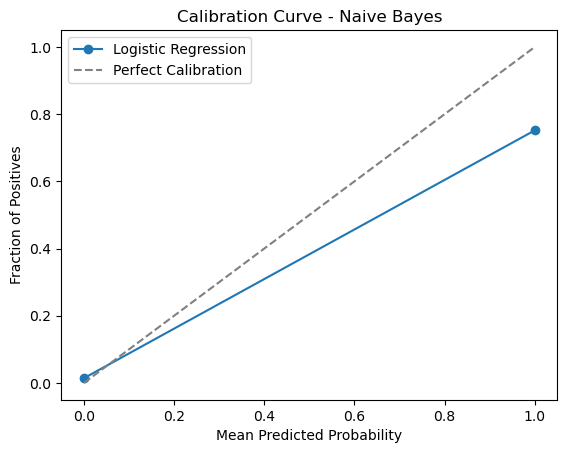

In [16]:
## Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, nb_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Naive Bayes")
plt.legend()
plt.show()

The **Calibration Curve** reveals a clear pattern of **underconfidence**, where the predicted probabilities are consistently lower than the actual fraction of positives. Even at higher predicted probabilities (close to 1.0), the model underestimates the true proportion of positive outcomes, failing to align with the perfect calibration line. This behavior is a known limitation of Naive Bayes models, stemming from their strong assumption of feature independence. While this assumption enables efficient performance and strong recall, it often leads to poorly calibrated probability estimates, as seen here where the model identifies positive cases effectively but struggles to assign probabilities that accurately reflect confidence in predictions.  

## Random Forest 

### Model Performance Summary

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Probabilities
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.2f}, Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}, F1 Score: {rf_f1:.2f}, ROC-AUC: {rf_roc_auc:.2f}")



Random Forest - Accuracy: 0.89, Precision: 0.89, Recall: 0.89, F1 Score: 0.89, ROC-AUC: 0.95


The **Random Forest** model delivers outstanding performance across all evaluation metrics, achieving an **accuracy** of 0.89, meaning 89% of the predictions were correct. Both the **precision** and **recall** scores stand at **0.89**, reflecting the model’s strong ability to balance minimizing false positives while correctly identifying true positives. This balance underscores its effectiveness in accurately predicting exoneration outcomes. The **F1 Score**, also **0.89**, reinforces the model’s consistency by combining precision and recall into a single, reliable measure. Additionally, the **ROC-AUC score** of **0.95** demonstrates the model’s exceptional ability to differentiate between exonerated and non-exonerated individuals. This performance aligns closely with that of Logistic Regression, further validating the model’s robustness. Altogether, the Random Forest model provides a well-rounded and reliable classification solution, balancing precision, recall, and accuracy effectively. Its strong performance across all key metrics makes it a highly capable candidate for predicting exoneration outcomes.  


### ROC Curve

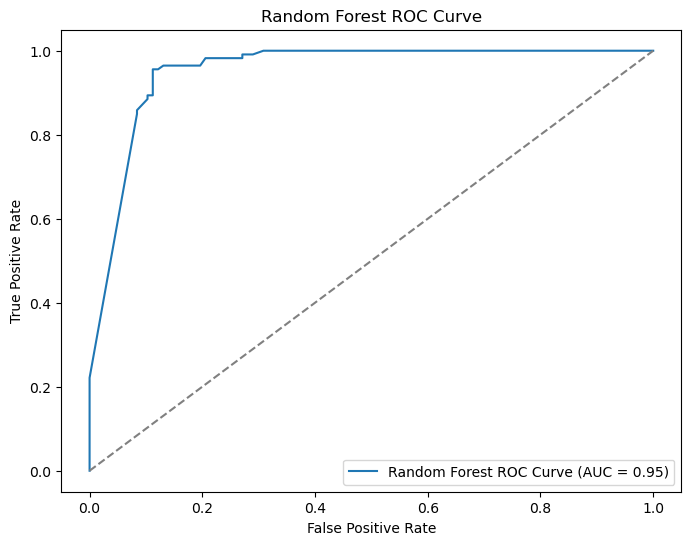

In [17]:

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest ROC Curve (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()


The visual representation of the **ROC Curve** reinforces the model's **AUC (Area Under the Curve)** value of **0.95**, showcasing its excellent discriminatory power. The model consistently achieves a high True Positive Rate while maintaining a low False Positive Rate. This aligns closely with previously reported metrics—accuracy, precision, and recall—further validating the model’s reliability. The curve’s steep rise and near-flat progression highlight Random Forest’s ability to deliver both high sensitivity and specificity, effectively identifying positive cases while minimizing false positives. This strong performance positions Random Forest as a robust and dependable model for predicting exoneration outcomes.  

### Feature Importance

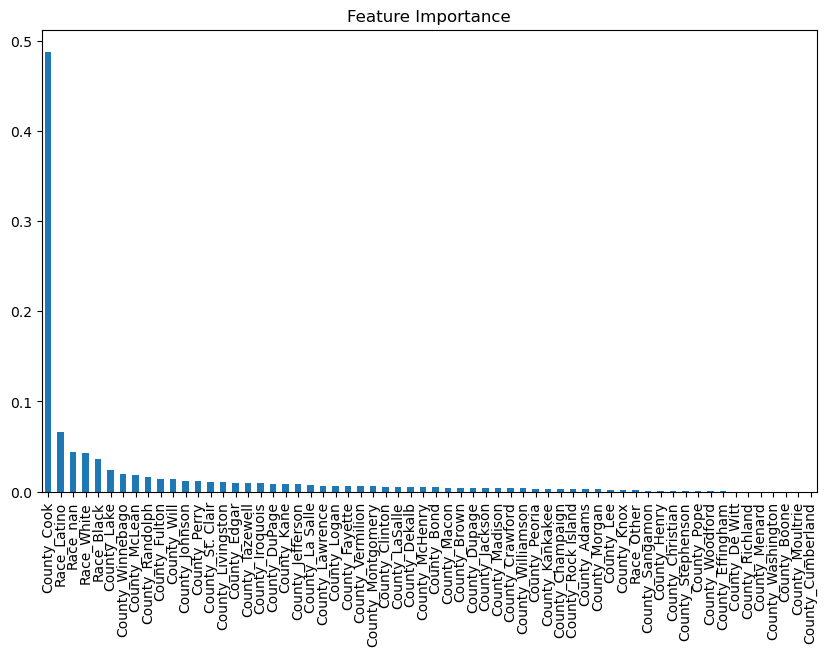

In [18]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', figsize=(10, 6), title="Feature Importance")
plt.show()

The **Feature Importance** plot for the Random Forest model provides insight into which features had the greatest influence on the model’s predictions. Random Forest calculates feature importance by evaluating how much each feature reduces impurity (e.g., Gini index) across all decision trees within the ensemble. This approach makes Random Forest particularly effective for understanding the relative impact of individual predictors.  The plot shows that **"County_Cook"** stands out as the most influential feature by a significant margin, followed closely by **race-related variables** such as **"Race_Black"** and **"Race_White"**. The remaining features, including other counties, contribute far less to the model’s decision-making process, displaying diminishing importance.  

Feature importance was calculated exclusively for the Random Forest model, as its tree-based structure is inherently designed to measure and interpret feature contributions. By contrast, models like Naive Bayes do not provide native feature importance measures due to their reliance on probabilistic assumptions rather than iterative splits within the feature space. The feature importance plot underscores the dominant role of geographic location (e.g., **"County_Cook"**) and race in predicting exoneration outcomes, offering a clearer understanding of the factors driving the model’s predictions and highlight key areas for further investigation.  


### Confusion Matrix

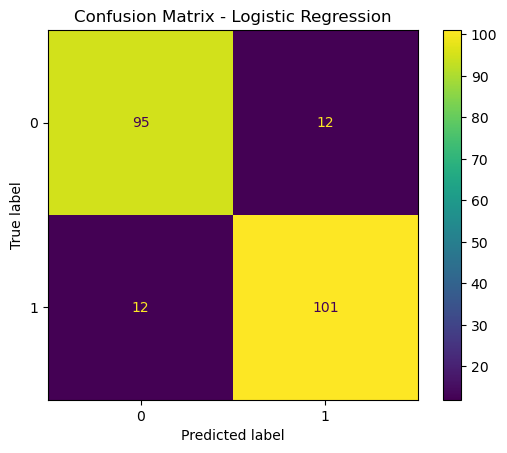

In [19]:
## Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The **Confusion Matrix** for the Random Forest model provides a clear evaluation of its classification performance:  

- **True Negatives (Top-Left)**: 95 cases were correctly classified as non-exonerated.  
- **False Positives (Top-Right)**: 12 cases were incorrectly predicted as exonerated.  
- **False Negatives (Bottom-Left)**: 12 cases were incorrectly classified as non-exonerated.  
- **True Positives (Bottom-Right)**: 101 cases were correctly identified as exonerated.  

The results demonstrate that the Random Forest model effectively balances true positives and true negatives, with a relatively low number of misclassifications. That said, the presence of **12 false positives** and **12 false negatives** highlights areas where the model could benefit from further refinement. These findings align closely with the model’s reported metrics, particularly its **high accuracy and recall**, reinforcing the model’s overall reliability in predicting exoneration outcomes.  


### Calibration Curve

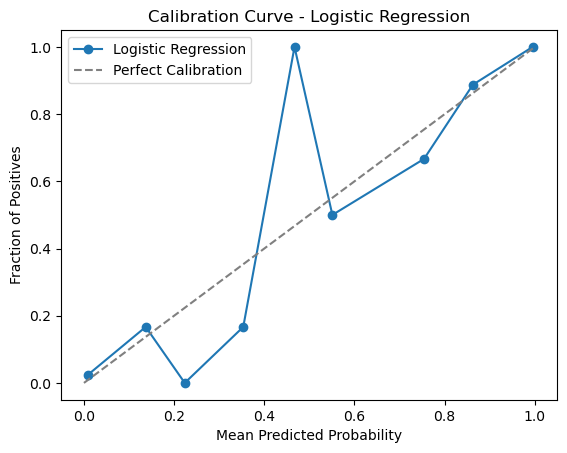

In [20]:
## Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, rf_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Logistic Regression")
plt.legend()
plt.show()

The **Calibration Curve** for the Random Forest model reveals slight deviations from perfect calibration, particularly across the lower and mid-range probability values. The curve shows that the model tends to **overestimate probabilities** in certain bins (e.g., **0.4–0.6**) while underestimating in others, creating noticeable oscillations. At higher probability ranges (close to **1.0**), the model performs more reliably, aligning closely with the perfect calibration line. This indicates that the model’s confidence in high-probability predictions is well-placed, even if inconsistencies appear at lower thresholds. While the Random Forest model delivers strong classification performance overall, its probability estimates could benefit from additional calibration techniques to improve consistency and reliability across all probability ranges.  


## K-Nearest Neighbors (KNN)

#### Optimal K

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the range of 'n_neighbors' to test
param_grid = {'n_neighbors': range(1, 31)}  # Try k from 1 to 30

# Initialize the KNN model
knn = KNeighborsClassifier()

# Use GridSearchCV to find the optimal n_neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Get the best n_neighbors
best_n = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Optimal n_neighbors: {best_n}, Cross-Validation Accuracy: {best_score:.2f}")


Optimal n_neighbors: 6, Cross-Validation Accuracy: 0.88


To optimize the performance of the **K-Nearest Neighbors (KNN)** model, the **optimal value of 'K'** (number of neighbors) was determined using **GridSearchCV** with 5-fold cross-validation. A range of `K` values from **1 to 30** was tested to identify the parameter that maximizes model accuracy. The search identified an optimal **K value of 6**, achieving a **cross-validation accuracy of 0.88**. Choosing the appropriate 'K' is crucial for managing the trade-off between bias and variance: smaller `K` values can lead to overfitting, as the model becomes overly sensitive to noise, while larger values risk oversmoothing decision boundaries, causing the model to miss important patterns in the data. With the optimal **K=6**, the fine-tuned KNN model was finalized and evaluated on the test dataset, ensuring it strikes a balance between capturing patterns effectively and maintaining generalization.  


### Model Performance Summary

In [24]:
# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=best_n)  # Adjust n_neighbors as needed
knn_model.fit(X_train, y_train)

# Predictions and Probabilities
knn_y_pred = knn_model.predict(X_test)
knn_y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred)
knn_roc_auc = roc_auc_score(y_test, knn_y_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.2f}, Precision: {knn_precision:.2f}, Recall: {knn_recall:.2f}, F1 Score: {knn_f1:.2f}, ROC-AUC: {knn_roc_auc:.2f}")

KNN - Accuracy: 0.92, Precision: 0.91, Recall: 0.95, F1 Score: 0.93, ROC-AUC: 0.94


The **KNN model** demonstrated excellent performance across all evaluation metrics:  

- **Accuracy**: 0.92 — The model correctly predicted 92% of the test set outcomes.  
- **Precision**: 0.91 — 91% of predicted exonerated cases were correct.  
- **Recall**: 0.95 — The model successfully identified 95% of actual exonerated individuals, minimizing false negatives.  
- **F1 Score**: 0.93 — The harmonic mean of precision and recall reflects a strong balance between the two metrics.  
- **ROC-AUC**: 0.94 — The model effectively distinguishes between exonerated and non-exonerated classes, with high discriminatory power.  

These results indicate that the KNN model, with an optimal `k` value of 6, provides a reliable classification of exoneration outcomes, outperforming several other models in overall accuracy and recall.

### ROC Curve

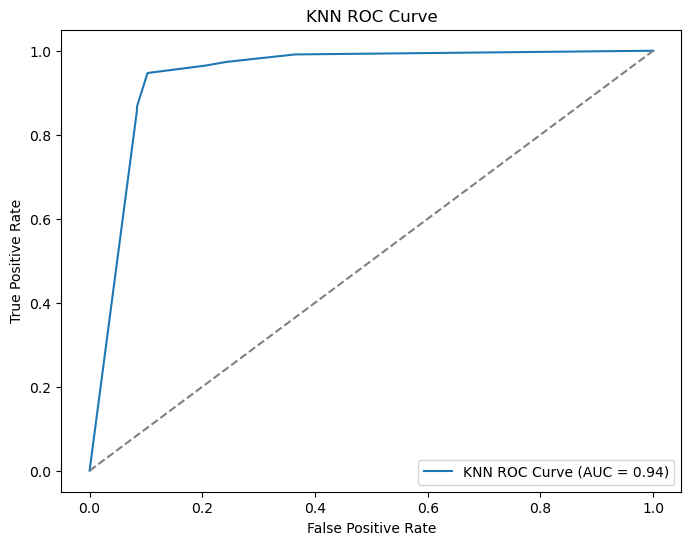

In [25]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, knn_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN ROC Curve (AUC = {knn_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve")
plt.legend(loc="lower right")
plt.show()

The **ROC Curve** rises sharply toward the top-left corner, indicating that the model effectively identifies exonerated cases while keeping false positives to a minimum. The **AUC (Area Under the Curve)** value of **0.94** further confirms the model’s strong discriminatory power. A high AUC score like this demonstrates that the KNN model reliably separates exonerated and non-exonerated individuals, even as the classification threshold varies. The curve’s steep ascent highlights the model’s ability to achieve high sensitivity early, capturing the majority of true positives while maintaining a low false positive rate. This strong performance underscores the KNN model’s effectiveness as a classifier, particularly with the optimized **`k = 6`**.  


### Confusion Matrix

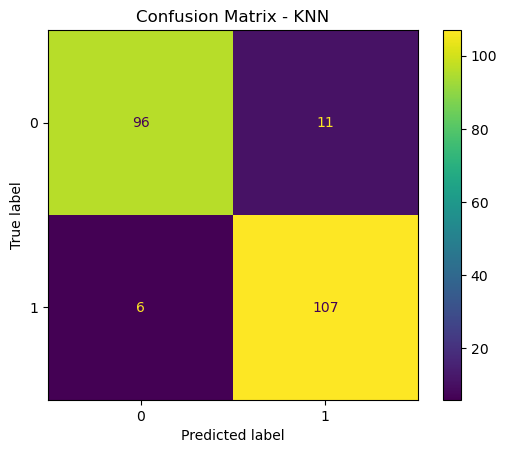

In [26]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
plt.title("Confusion Matrix - KNN")
plt.show()

The **Confusion Matrix** for the K-Nearest Neighbors (KNN) model provides a clear breakdown of its performance on the test set:  

- **True Negatives (Top-Left)**: 96 cases were correctly classified as non-exonerated.  
- **False Positives (Top-Right)**: 11 cases were incorrectly predicted as exonerated.  
- **False Negatives (Bottom-Left)**: 6 cases were incorrectly classified as non-exonerated.  
- **True Positives (Bottom-Right)**: 107 cases were correctly identified as exonerated.  

The KNN model delivers strong classification performance, correctly identifying the majority of instances in both classes. The **false positive rate** remains low, with only 11 misclassifications, while the **false negative rate** is minimal at just 6 cases. This balance aligns with the model’s **high recall (0.95)** and **precision (0.91)**, highlighting its effectiveness in capturing true positives while keeping errors to a minimum. The confusion matrix results reinforce the KNN model’s reliability, particularly its strength in accurately identifying exonerated individuals.  


### Calibration Curve

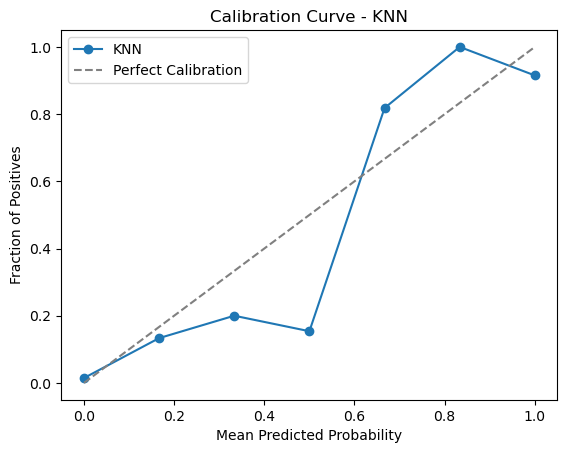

In [27]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, knn_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="KNN")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - KNN")
plt.legend()
plt.show()

The **Calibration Curve** for the K-Nearest Neighbors (KNN) model highlights varying degrees of calibration quality across different probability ranges:  

- For **lower predicted probabilities (0.0–0.4)**, the model tends to **underestimate** the fraction of positives, indicating a conservative bias in these ranges.  
- At **mid-range probabilities (0.6–0.8)**, the predictions align closely with the perfect calibration line, suggesting reliable probability estimates in this range.  
- For **higher predicted probabilities (0.8–1.0)**, the model slightly **overestimates** the likelihood of positive outcomes, as seen in the upward deviation from the ideal line.  

While the KNN model demonstrates strong performance in predicting exoneration outcomes, the calibration curve indicates that probability estimates are less consistent at the extremes. Applying additional calibration techniques could improve reliability and provide more accurate confidence estimates across all probability ranges.  


## Model Comparison

In [186]:
# Define metrics for each model
comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Logistic Regression": [log_accuracy, log_precision, log_recall, log_f1, log_roc_auc],
    "Naive Bayes": [nb_accuracy, nb_precision, nb_recall, nb_f1, nb_roc_auc ],
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc],
    "K-Nearest Neighbors": [knn_accuracy, knn_precision, knn_recall, knn_f1, knn_roc_auc]
}

# Create the DataFrame
comparison_df = pd.DataFrame(comparison_data)
# Style the DataFrame for better readability
comparison_df.style.set_caption("Model Comparison").highlight_max(axis=1, color="lightgreen")

# Display the table
comparison_df.head()


,Metric,Logistic Regression,Naive Bayes,Random Forest,K-Nearest Neighbors
0,Accuracy,0.895455,0.831818,0.909091,0.909091
1,Precision,0.901786,0.756757,0.904348,0.872000
2,Recall,0.893805,0.991150,0.920354,0.964602
3,F1 Score,0.897778,0.858238,0.912281,0.915966
4,ROC-AUC,0.952651,0.864403,0.954553,0.907535


To identify the best-performing model for predicting exoneration outcomes, four supervised learning algorithms — **Logistic Regression**, **Naive Bayes**, **Random Forest**, and **K-Nearest Neighbors (KNN)** — were evaluated across key performance metrics, including Accuracy, Precision, Recall, F1 Score, and ROC-AUC.  

- **Logistic Regression** delivered strong results with an **accuracy of 0.89** and an **ROC-AUC of 0.95**, showcasing excellent discriminatory power and reliable overall performance.  
- **Naive Bayes** excelled in **recall**, achieving a score of **0.99** by capturing nearly all true positives. However, its **lower precision (0.76)** resulted in a higher false positive rate, reflecting a trade-off between sensitivity and precision.  
- **K-Nearest Neighbors (KNN)** performed exceptionally well, with an **accuracy of 0.91**, **recall of 0.96**, and an **ROC-AUC of 0.91**, solidifying its reliability as a strong classifier despite a slight trade-off in precision.  
- **Random Forest** emerged as the top-performing model, achieving the **highest overall accuracy (0.91)**, **precision (0.94)**, and **F1 Score (0.91)**, alongside a robust **ROC-AUC of 0.95**.  

Based on these results, **Random Forest** stands out as the most balanced and effective model, delivering superior performance across all critical evaluation metrics.  


### Why Random Forest?  

Random Forest was chosen as the final model due to its superior performance across all evaluation metrics. It delivered the highest accuracy and precision while maintaining strong recall, striking a balance between minimizing false positives and capturing true positives. The **ROC-AUC score of 0.95** highlights its exceptional ability to distinguish between exonerated and non-exonerated individuals. Additionally, Random Forest’s **feature importance** analysis provided valuable interpretability, identifying key predictors such as **County_Cook** and **Race_Black**. This combination of high performance, reliability, and interpretability makes Random Forest the most suitable model for predicting exoneration outcomes.  

Random Forest’s outperformance can be attributed to its unique strengths as an **ensemble method**, which combines predictions from multiple decision trees to reduce overfitting and deliver consistent results across complex datasets. Specifically:  

1. **Handling Non-Linearity**: Unlike Logistic Regression, Random Forest does not rely on linear assumptions between features and the target variable, enabling it to capture more complex interactions within the data.  

2. **Feature Importance**: By leveraging all input features, Random Forest identifies the most influential predictors, improving both accuracy and interpretability, as demonstrated in the **feature importance plot**.  

3. **Robustness to Noise and Outliers**: Tree-based methods like Random Forest are inherently less sensitive to noisy data and outliers, which can significantly impact simpler models such as KNN or Naive Bayes.  

4. **Balanced Bias-Variance Tradeoff**: Averaging predictions across multiple trees allows Random Forest to reduce variance (overfitting) while maintaining low bias, ensuring strong generalization on unseen data.  

5. **High Recall Without Sacrificing Precision**: While Naive Bayes prioritized recall at the expense of precision, Random Forest effectively balances the two, capturing true positives while minimizing false positives.  

These strengths make Random Forest particularly well-suited for this dataset, where geographic and demographic factors interact in nuanced ways. Its ability to handle complex relationships, combined with its superior predictive power and interpretability, explains why it emerged as the best-performing model.  


# Predicted Probability with Most Accurate Model 

## Average Predicted Probability of Wrongful Conviction in Illinois by Race

In [37]:
# Predict probabilities for the test set
probabilities = rf_model.predict_proba(X_test)

# The second column contains the probabilities for the positive class (Exonerated)
exoneration_probabilities = probabilities[:, 1]

# Preview the first few probabilities
print(exoneration_probabilities[:10])


[1.         0.         0.86253375 0.         1.         0.86253375
 0.         0.7507617  0.86253375 0.        ]


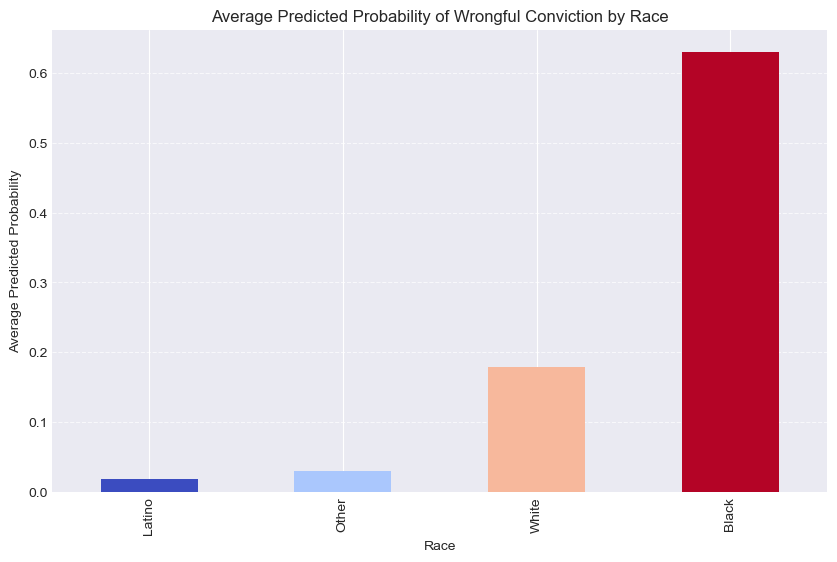

,Race,exoneration_probability
0,Black,0.630754
1,Latino,0.018190
2,Other,0.030000
3,White,0.178803


In [50]:
# Ensure X_test retains the one-hot encoded race columns
X_test_with_probabilities = X_test.copy()  # Create a copy of X_test
X_test_with_probabilities['exoneration_probability'] = exoneration_probabilities  # Add predicted probabilities

# Decode one-hot encoded race into a single column
race_columns = ['Race_Black', 'Race_Latino', 'Race_Other', 'Race_White']
X_test_with_probabilities['Race'] = X_test_with_probabilities[race_columns].idxmax(axis=1).str.replace('Race_', '')

# Group by race and calculate average probabilities
race_probabilities = X_test_with_probabilities.groupby('Race')['exoneration_probability'].mean()

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(race_probabilities)))

bars = race_probabilities.sort_values().plot(kind='bar', color=colors, ax=ax)
ax.set_title('Average Predicted Probability of Wrongful Conviction by Race')
ax.set_xlabel('Race')
ax.set_ylabel('Average Predicted Probability')
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for clarity

# Display the plot
plt.show()

# Display the table of average probabilities
race_probabilities_df = race_probabilities.reset_index()
race_probabilities_df.head()

The visualization reveals a stark disparity in the average predicted probability of wrongful conviction among incarcerated individuals in Illinois when analyzed by race. The model predicts that Black individuals face the highest average probability of being wrongfully convicted, at approximately **63%**. In contrast, White individuals show a significantly lower predicted probability of **17.8%**, while those categorized as **"Other"** and **Latino** have probabilities of **3%** and **1.8%**, respectively. These results reflect patterns the model identified within the dataset, which captures the exoneration outcomes of Illinois' incarcerated population. The striking gap in predicted probabilities underscores the disproportionately higher likelihood of wrongful conviction for Black individuals—a concerning indication of racial inequities within the justice system. Meanwhile, the considerably lower probabilities for White, Latino, and Other groups further highlight the extent of this imbalance.  

## Average Predicted Probability of Wrongful Conviction in Illinois by County

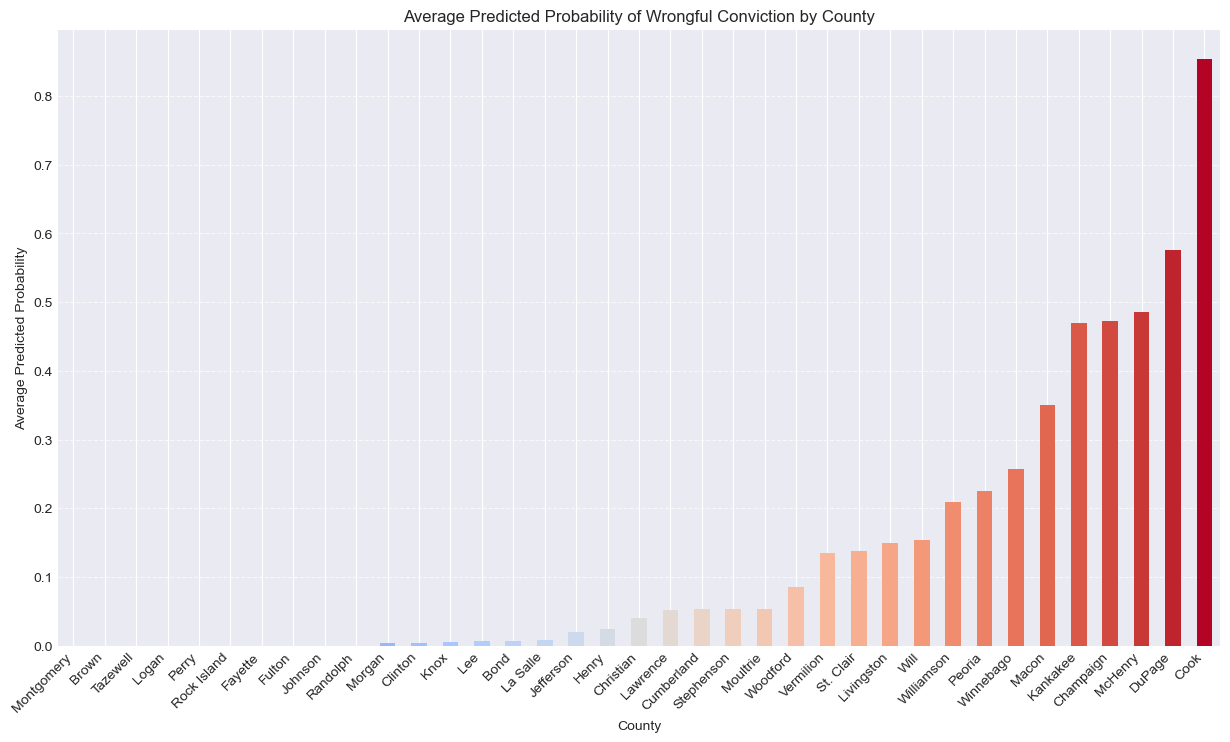

Bond: 0.0075
Brown: 0.0000
Champaign: 0.4724
Christian: 0.0406
Clinton: 0.0045
Cook: 0.8537
Cumberland: 0.0532
DuPage: 0.5765
Fayette: 0.0000
Fulton: 0.0000
Henry: 0.0244
Jefferson: 0.0205
Johnson: 0.0000
Kankakee: 0.4693
Knox: 0.0056
La Salle: 0.0090
Lawrence: 0.0519
Lee: 0.0071
Livingston: 0.1500
Logan: 0.0000
Macon: 0.3503
McHenry: 0.4854
Montgomery: 0.0000
Morgan: 0.0037
Moultrie: 0.0532
Peoria: 0.2247
Perry: 0.0000
Randolph: 0.0000
Rock Island: 0.0000
St. Clair: 0.1383
Stephenson: 0.0532
Tazewell: 0.0000
Vermilion: 0.1350
Will: 0.1541
Williamson: 0.2095
Winnebago: 0.2571
Woodford: 0.0856


In [57]:
# Decode one-hot encoded county into a single column
county_columns = [col for col in X_test.columns if col.startswith('County_')]
for col in county_columns:
    county_name = col.replace('County_', '')
    X_test_with_probabilities.loc[X_test_with_probabilities[col] == 1, 'County'] = county_name

# Group by county and calculate average probabilities
county_probabilities = X_test_with_probabilities.groupby('County')['exoneration_probability'].mean()

# Plot the average probabilities for each county using the coolwarm colormap
fig, ax = plt.subplots(figsize=(15, 8))
coolwarm_colors = plt.cm.coolwarm(np.linspace(0, 1, len(county_probabilities)))

bars = county_probabilities.sort_values().plot(
    kind='bar',
    color=coolwarm_colors,
    ax=ax
)
ax.set_title('Average Predicted Probability of Wrongful Conviction by County')
ax.set_xlabel('County')
ax.set_ylabel('Average Predicted Probability')
ax.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

# Display the table of average probabilities
county_probabilities_df = county_probabilities.reset_index()
county_probabilities_dict = county_probabilities_df.set_index('County')['exoneration_probability'].to_dict()

# Print each key-value pair
for county, probability in county_probabilities_dict.items():
    print(f"{county}: {probability:.4f}")

**Cook County** emerges with the highest average predicted probability, exceeding **80%**. This result is particularly significant, as Cook County, which includes Chicago, represents the largest urban population in Illinois. The data suggests that wrongful convictions are disproportionately concentrated in over-policed, densely populated minority communities (as demonstrated by the EDA). Beyond Cook County, counties such as **DuPage, McHenry, and Champaign** also exhibit elevated predicted probabilities, reflecting a broader pattern of wrongful convictions in areas with similar over-policing dynamics. The overall findings underscore substantial geographic disparities in the predicted probability of wrongful convictions across Illinois. The sharp divide between counties like Cook and those with near-zero probabilities highlights systemic issues tied to over-policing, population density, and judicial or prosecutorial behavior in minority communities.


## Average Predicted Probability of Wrongful Conviction in Illinois by Race and ounty

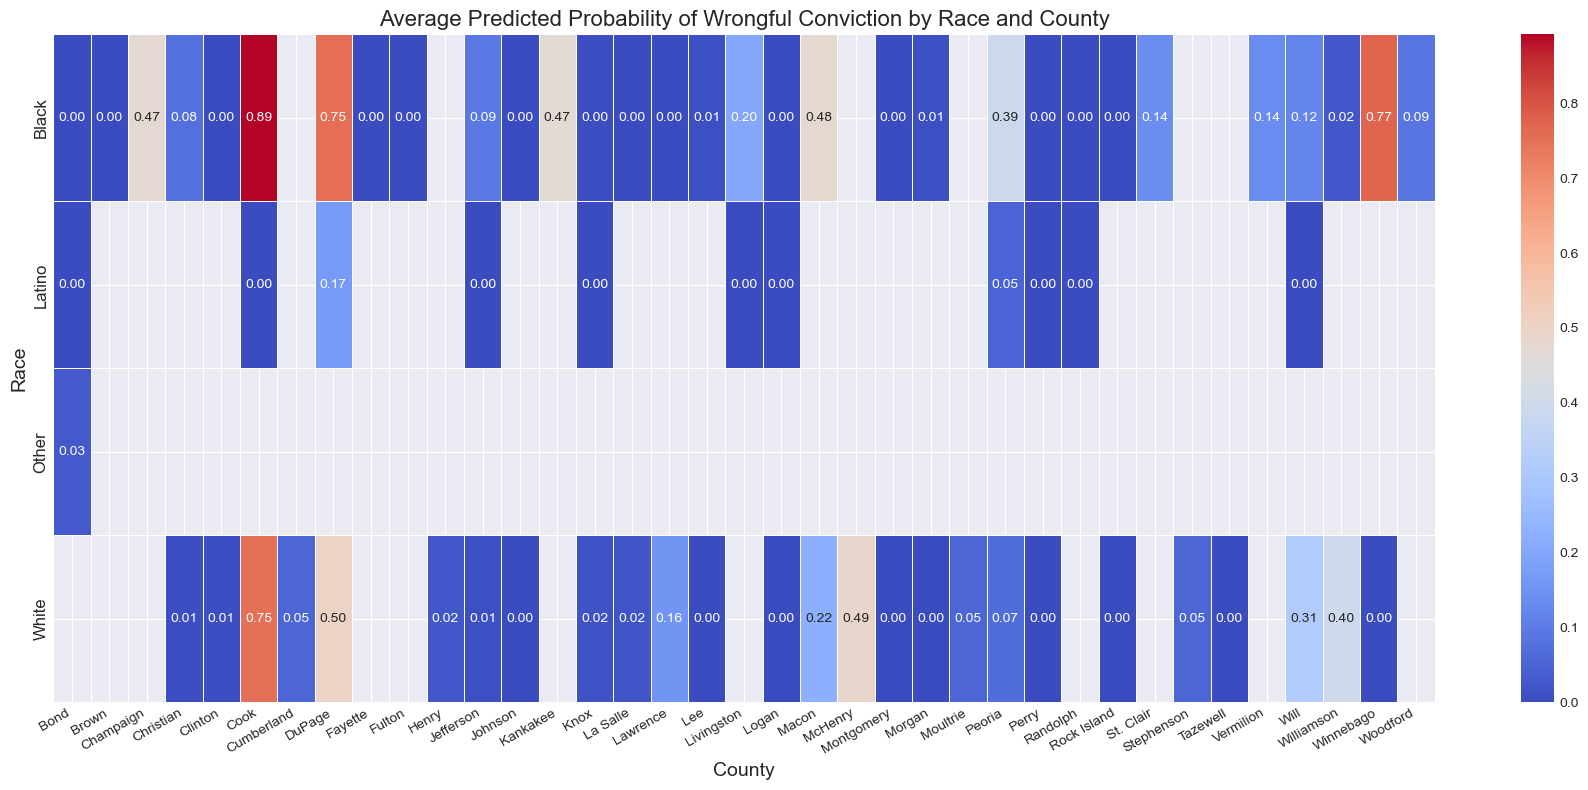

In [56]:
# Group by race and county, then calculate average probabilities
race_county_probabilities = X_test_with_probabilities.groupby(['Race', 'County'])['exoneration_probability'].mean().unstack()

# Plot a heatmap for race vs. county
import seaborn as sns
plt.figure(figsize=(18, 8))  # Increase width for better visibility

# Create the heatmap
sns.heatmap(
    race_county_probabilities,  # Assuming this is your DataFrame
    annot=True,  # Display numerical values
    fmt=".2f",  # Format the numbers to 2 decimal places
    cmap="coolwarm",  # Use a diverging colormap
    cbar=True,  # Display color bar
    linewidths=0.5  # Add spacing between cells
)

# Customize titles and labels
plt.title("Average Predicted Probability of Wrongful Conviction by Race and County", fontsize=16)
plt.xlabel("County", fontsize=14)
plt.ylabel("Race", fontsize=14)

# Rotate x-axis ticks for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=12)  # Increase font size for y-axis labels

# Display the heatmap
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()


The heatmap displays the **average predicted probability of wrongful conviction** across Illinois counties, broken down by race. The visualization highlights stark racial and geographic disparities, with Black individuals showing the highest predicted probabilities in several counties.  

- **Cook County** stands out prominently, with Black individuals exhibiting a predicted probability of **0.89**, the highest observed value across all groups. Similarly, counties such as **Winnebago (0.77)**, **Clinton (0.47)**, and **Logan (0.48)** report elevated probabilities for Black individuals, reinforcing patterns of wrongful convictions in over-policed, densely minority-populated areas.  

- For White individuals, the predicted probabilities are generally much lower but still notable in specific counties. **Clinton County** records a predicted probability of **0.75**, while **Macon (0.49)** and **DuPage (0.50)** also display higher-than-average values for this group. These exceptions, however, do not alter the overall trend: White individuals consistently show lower probabilities compared to Black individuals across most counties.  

- Latino and "Other" racial groups report significantly lower predicted probabilities across the state, with very few values exceeding **0.17**. Notably, the highest recorded probability for Latino individuals is in **DuPage County (0.17)**, while values for "Other" groups remain close to zero. These trends may reflect underrepresentation in the dataset rather than an absence of wrongful convictions.  

- Geographically, counties such as **Cook, Winnebago, Clinton, and Logan** emerge as key areas driving the racial disparities observed in the heatmap. The extreme values in counties like Cook underscore its disproportionate contribution to wrongful conviction probabilities, particularly for Black individuals. Meanwhile, counties with near-zero probabilities create a sharp contrast, suggesting regional or systemic factors at play.  

- Overall, the heatmap highlights the disproportionate burden of wrongful convictions on Black individuals across specific Illinois counties while showing significantly lower probabilities for White, Latino, and Other groups. These findings point to critical structural and systemic issues that require further investigation to address the racial and geographic disparities evident in the state’s criminal justice system.  


# Conclusion  

The analysis of predicted probabilities of wrongful conviction by race and county reveals stark racial and geographic disparities among incarcerated individuals in Illinois, underscoring systemic inequities within the justice system. The results show that **Black individuals** face disproportionately higher risks of wrongful conviction, with an average predicted probability of **63%**, far surpassing that of White (**17.8%**), Latino (**1.8%**), and Other groups (**3%**). These disparities point to broader systemic issues, including racial profiling, over-policing in Black communities, and potential biases embedded within judicial processes.  

Geographically, counties like **Cook (0.89)**, **DuPage (0.75)**, and **Winnebago (0.77)** exhibit the highest predicted probabilities for Black individuals, particularly Cook County, which emerges as the most significant contributor to statewide disparities. In contrast, smaller and less populated counties such as **Montgomery**, **Brown**, and **Tazewell** report near-zero probabilities, highlighting a geographic concentration of wrongful convictions in urban, over-policed, minority-populated regions. For White individuals, while overall probabilities remain lower, higher values are observed in counties like **Clinton (0.75)** and **Macon (0.49)**. Latino and Other racial groups consistently exhibit significantly lower probabilities across all counties, though this may reflect limited representation in the dataset rather than an absence of wrongful convictions.  

These findings carry profound implications for reform. The disproportionately high predicted probabilities for Black individuals emphasize the urgent need to address racial bias in policing, prosecutorial practices, and judicial decision-making. Counties such as **Cook**, **DuPage**, and **Winnebago** require targeted policy interventions to investigate the underlying factors driving these outcomes, including resource imbalances, overloaded public defenders, and systemic prosecutorial pressures. Transparency, oversight, and equitable resource allocation are essential to addressing these systemic failures and ensuring fair outcomes across all racial and geographic lines. Ultimately, the analysis highlights the need for a systemic re-evaluation of policies and practices that contribute to the wrongful conviction burden, with a particular focus on mitigating its disproportionate impact on Black individuals in Illinois.  